In [ ]:
# 下载数据
# https://www.kaggle.com/gaurav2022/mobile-health
# !kaggle datasets download -d gaurav2022/mobile-health

# 1.Library

In [1]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import plot_importance

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import time
import sys

# 2. Load Data

In [2]:
# load data and split
data = pd.read_csv("mhealth_raw_data.csv")
data.shape

(1215745, 14)

# 3. EDA

In [3]:
def data_info(data):
    print('---------------------------数据概要----------------------------\n',
          data.head(5),
          '\n--------------------------------------------------------------\n',
          data.info(),
          '\n---------------------subject value counts---------------------\n',
          data['subject'].value_counts(),
          '\n---------------------Activity value counts--------------------\n',
          data['Activity'].value_counts()
          )
    %matplotlib inline
    data.hist(bins = 50, figsize=(20,15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215745 entries, 0 to 1215744
Data columns (total 14 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   alx       1215745 non-null  float64
 1   aly       1215745 non-null  float64
 2   alz       1215745 non-null  float64
 3   glx       1215745 non-null  float64
 4   gly       1215745 non-null  float64
 5   glz       1215745 non-null  float64
 6   arx       1215745 non-null  float64
 7   ary       1215745 non-null  float64
 8   arz       1215745 non-null  float64
 9   grx       1215745 non-null  float64
 10  gry       1215745 non-null  float64
 11  grz       1215745 non-null  float64
 12  Activity  1215745 non-null  int64  
 13  subject   1215745 non-null  object 
dtypes: float64(12), int64(1), object(1)
memory usage: 129.9+ MB
---------------------------数据概要----------------------------
       alx     aly      alz       glx      gly      glz     arx     ary  \
0  2.1849 -9.6967  0.63077  0.1

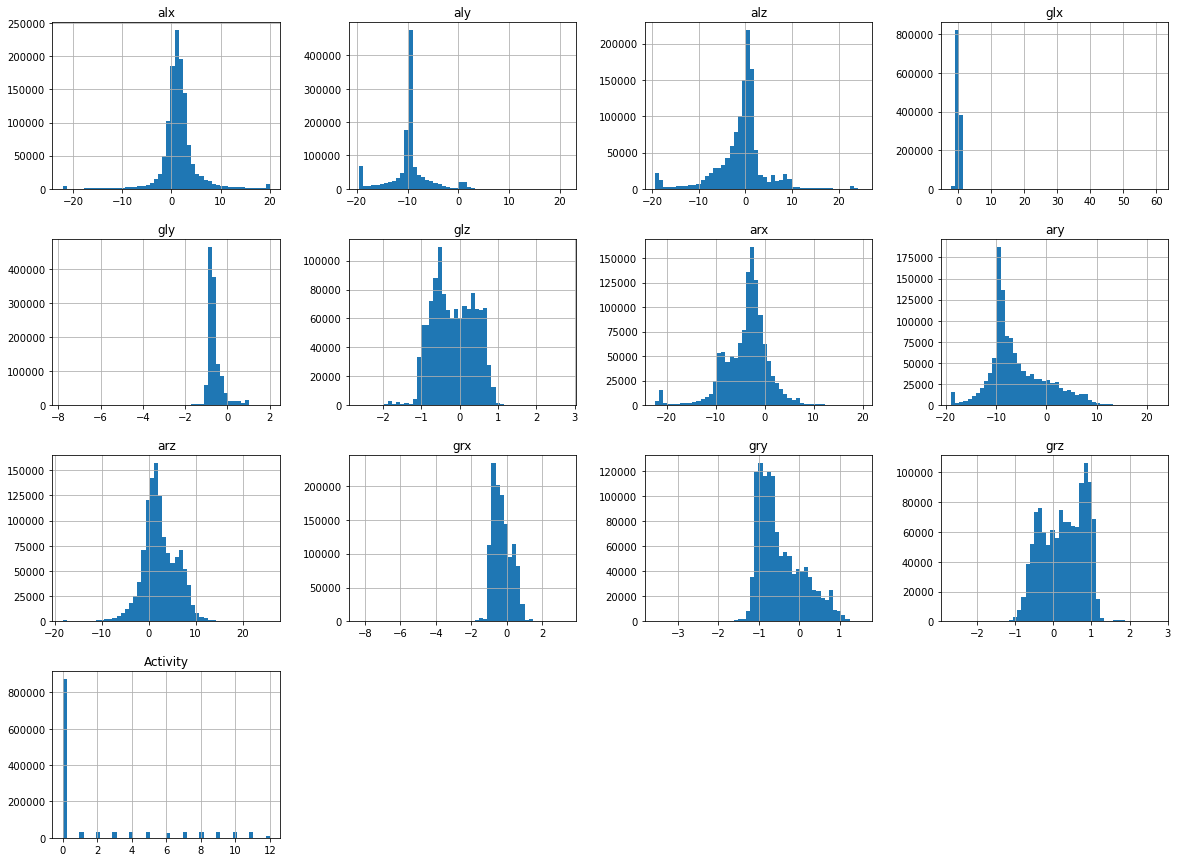

In [4]:
data_info(data)

# 4. Data Preprocessing

In [5]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
# Lets shuffle the data before creating the subsamples

def split_dataset(dataset, under_sampling = False, over_sampling = False, unsplit = False):
    if under_sampling == True:

        data = dataset.sample(frac=1)
        # amount of bias classes 30720 rows.
        biased_class = data.loc[dataset['Activity'] == 0][:30720]
        normal_class = data.loc[dataset['Activity'] !=0]

        normal_distributed_df = pd.concat([biased_class, normal_class])

        # Shuffle dataframe rows
        df = normal_distributed_df.sample(frac=1, random_state=42)
#             new_df.head()
        X = df.iloc[:,:-2] # 去除Subject和Activitiy
        y = df.iloc[:,-2]  # 只提取 Activity
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, shuffle=False, random_state=0)
        if over_sampling == True:
            smote = SMOTE()
            X_train, y_train = smote.fit_resample(X_train, y_train)
            print('Dataset after under-sampling and over-sampling:\n\tX train size:{}\n\tX test size:{}\n\ty train size:{}\n\ty test size:{}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
        else:
            print('Dataset after under-sampling:\n\tX train size:{}\n\tX test size:{}\n\ty train size:{}\n\ty test size:{}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
            
    elif under_sampling == False:
        X = dataset.copy().iloc[:,:-2] # 去除Subject和Activitiy
        y = dataset.copy().iloc[:,-2]  # 只提取 Activity
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, shuffle=False, random_state=0)
        
        if over_sampling == True:
            smote = SMOTE()
            X_train, y_train = smote.fit_resample(X_train, y_train)
            print('Dataset after over-sampling:\n\tX train size:{}\n\tX test size:{}\n\ty train size:{}\n\ty test size:{}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
        else:
            print('Dataset:\n\tX train size:{}\n\tX test size:{}\n\ty train size:{}\n\ty test size:{}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

    %matplotlib inline
    label_data = pd.concat([y_train,y_test])
    label_data.hist(bins = 50, figsize=(4,3))
    if unsplit == True:
        return X, y
    else:
        return X_train, X_test, y_train, y_test

Dataset after under-sampling and over-sampling:
	X train size:(240825, 12)
	X test size:(149566, 12)
	y train size:(240825,)
	y test size:(149566,)


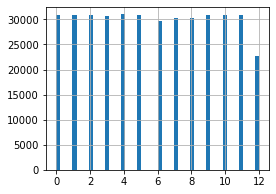

In [6]:
X_train, X_test, y_train, y_test = split_dataset(data, under_sampling = True, over_sampling = True)

# 5. Modeling

## 5.1 Classical Machine Learning

In [7]:
class MachineLearning:
    def __init__(self):
        self.model = None
    def logistic_regression(self):
        model = LogisticRegression()
        model.fit(X_train, y_train)
        self.model = model
        return model
    def lgbm(self):
        model = LGBMClassifier(n_estimators=400)
        model.fit(X_train, y_train, eval_metric="logloss", verbose=True) # eval_set=evals, early_stopping_rounds=100,
        self.model = model
        return model
    def xgboost(self):
        model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=160, silent=True, objective='multi:softmax')
        model.fit(X_train, y_train)
        self.model = model
        return model
    def catboost(self):
        model = CatBoostClassifier(verbose=0, n_estimators=100)
        model.fit(X_train,y_train)
        self.model = model
        return model
    def voting_classifier(self):
        model = VotingClassifier(estimators = base_model, voting = 'soft')
        model.fit(X_train, y_train)
        self.model = model
        return model
    def stacking_classifier(self):
        lr = LogisticRegression()
        model = StackingClassifier( estimators = base_model, final_estimator = lr)
        model.fit(X_train, y_train)
        self.model = model
        return model
        

## 5.2. Deep Neural Network

In [8]:
def dnn():
    dnn_model = models.Sequential()
    dnn_model.add(layers.Dense(units=64,kernel_initializer='normal',activation='relu',input_dim=X_train.shape[1]))
#     dnn_model.add(layers.Dense(units=128,kernel_initializer='normal',activation='relu'))
    dnn_model.add(layers.Dropout(0.3))
    dnn_model.add(layers.Dense(units=128,kernel_initializer='normal',activation='relu'))
    dnn_model.add(layers.Dropout(0.2))
    dnn_model.add(layers.Dense(units=64,kernel_initializer='normal',activation='relu'))
    dnn_model.add(layers.Dense(units=13,kernel_initializer='normal',activation='softmax'))
    return dnn_model

In [9]:
def model_builder(model, epochs = 30):
    y_train_le = LabelEncoder().fit_transform(y_train)
    y_test_le = LabelEncoder().fit_transform(y_test)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
    history = model.fit(X_train, y_train_le, batch_size = 128, epochs= epochs,validation_data = (X_test,y_test_le))
    path = './saved_model/'+ model.name +'.h5'
    model.save(path)
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    
    return history

# 6. Predict and Validation pipeline

In [10]:
def predict_result(model_name, method, start_time, model, history = None):
    spend = round(time.time() - start_time)
    y_pred = model.predict(X_test)
    if method == 'dl':
#     if y_pred.shape !=y_test.shape:
        y_pred = np.argmax(y_pred, axis=1)
#     if y_pred.shape !=X_test.iloc[:,0].shape:
#         y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(matrix,
                cmap='viridis',
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    print("time elapsed : {}s".format(spend))
    if method =='dl':
        epochs = len(history.history['accuracy'])
        acc = history.history['accuracy'][-1]
        loss = history.history['loss'][-1]
        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        data = "model : {}\tmethod : {}\tepochs : {}\tacc : {}\tloss : {}\tval_acc : {}\tval_loss : {}\tweight_name : {}-{}\n".format(model.name, method, epochs, round(acc,3), round(loss,3), round(val_acc,3), round(val_loss,3),round(epochs,2),round(val_loss,4))
    else :
        data = "model : {}\tmethod : {}\tacc : {}\terror : {}\ttime elapsed : {}s\n".format(model_name, method, acc, 1-acc, spend)
    with open("../HF_AI_FINAL/model_result.txt", 'a') as f:
        f.write(data)

In [11]:
def pipeline(method, model):
    start_time = time.time()
    method = method
    model_name = model.__name__
#     print(model_name)
#     if model_name.find('classifer') == -1:
    model = model()
    if method == 'dl':
        history = model_builder(model) 
        predict_result(model_name,method,start_time,model,history)
    else:
        predict_result(model_name,method,start_time,model)
    return model    

# 7. Model Training

In [12]:
ml = MachineLearning()

In [13]:
# base_model = [(ml.logistic_regression.__name__,ml.logistic_regression()),
#              (ml.lgbm.__name__,ml.lgbm()),
#              (ml.xgboost.__name__, ml.xgboost()),
#              (ml.catboost.__name__, ml.catboost())]

## A. Logistic regression
    

C:\Users\jungi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


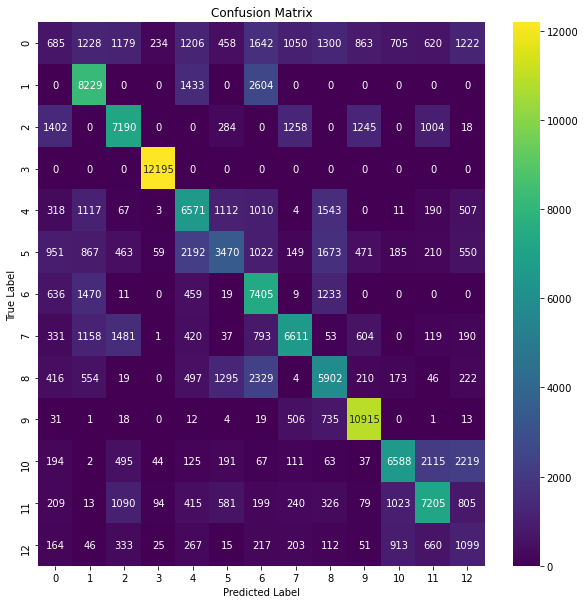

Test Accuracy: 56.21%
time elapsed : 16s


In [14]:
logistic_regression = pipeline('ml',ml.logistic_regression)

## B. LightGBM

C:\Users\jungi\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


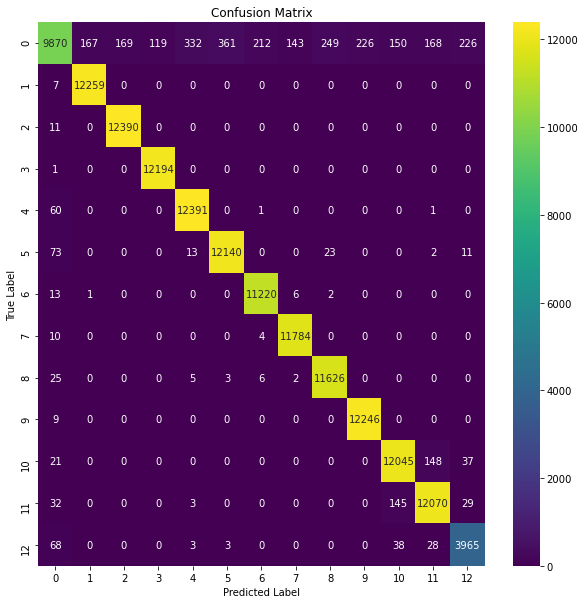

Test Accuracy: 97.75%
time elapsed : 18s


In [15]:
lightgbm = pipeline('ml',ml.lgbm)

## C. XGBoost

[19:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\jungi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:35:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


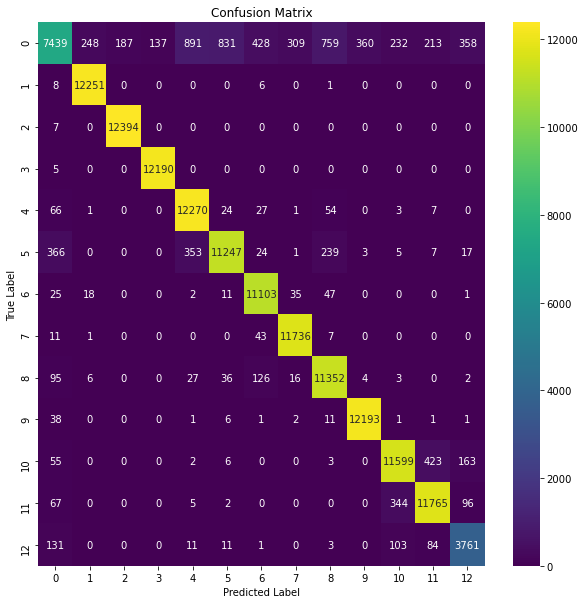

Test Accuracy: 94.47%
time elapsed : 104s


In [16]:
xgboost = pipeline('ml',ml.xgboost)

## D. CatBoost

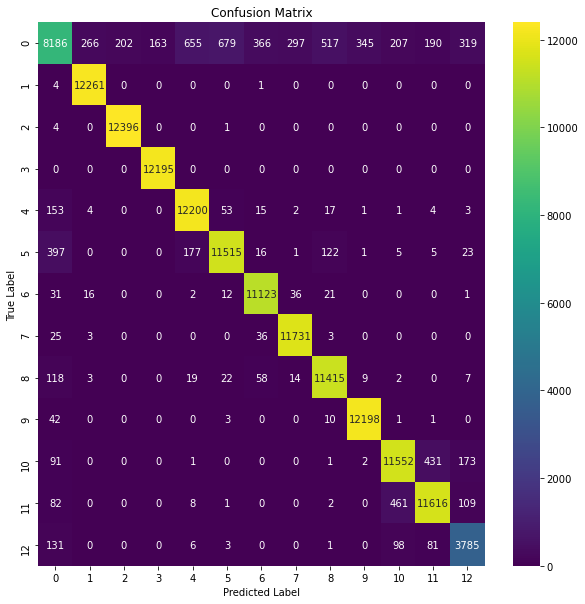

Test Accuracy: 95.06%
time elapsed : 15s


In [17]:
catboost = pipeline('ml',ml.catboost)

## E. Ensemble

In [18]:
# base model list
base_model = [(ml.logistic_regression.__name__,logistic_regression),
             (ml.lgbm.__name__,lightgbm),
             (ml.xgboost.__name__, xgboost),
             (ml.catboost.__name__, catboost)]

### E-1. Voting classifier

C:\Users\jungi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jungi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


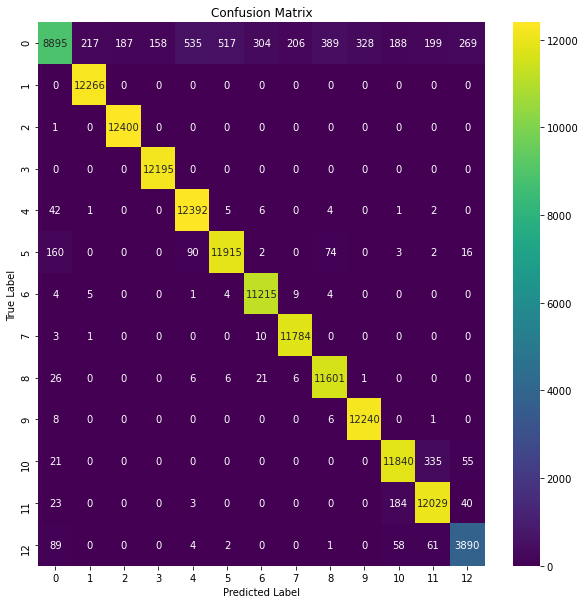

Test Accuracy: 96.72%
time elapsed : 159s


In [19]:
votingclassifier = pipeline('ml',ml.voting_classifier)

### E-2. Stacking Classifier

C:\Users\jungi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jungi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:40:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:40:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jungi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jungi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[19:45:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:45:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jungi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:46:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:46:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jungi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:48:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jungi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:49:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jungi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:51:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jungi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


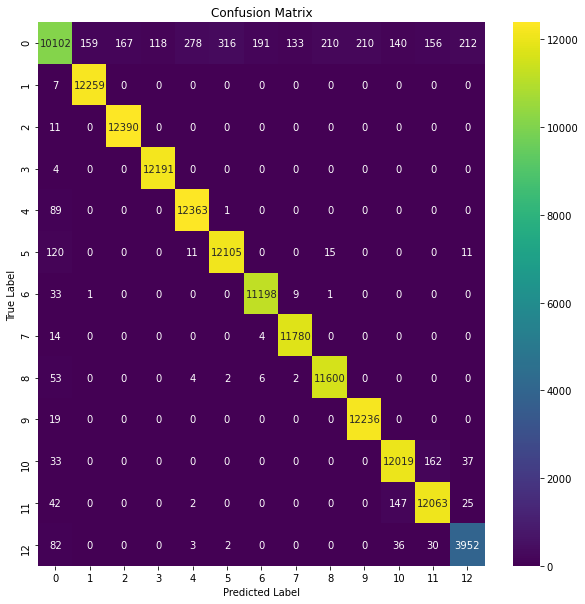

Test Accuracy: 97.79%
time elapsed : 841s


In [20]:
stackingclassifier = pipeline('ml',ml.stacking_classifier)

## F. Deep neural network

Epoch 1/30
1882/1882 [==============================] - 10s 4ms/step - loss: 1.0504 - accuracy: 0.6303 - val_loss: 0.6608 - val_accuracy: 0.7704
Epoch 2/30
1882/1882 [==============================] - 8s 4ms/step - loss: 0.7190 - accuracy: 0.7495 - val_loss: 0.5161 - val_accuracy: 0.8255
Epoch 3/30
1882/1882 [==============================] - 7s 4ms/step - loss: 0.6273 - accuracy: 0.7818 - val_loss: 0.4731 - val_accuracy: 0.8355
Epoch 4/30
1882/1882 [==============================] - 7s 4ms/step - loss: 0.5783 - accuracy: 0.7990 - val_loss: 0.4292 - val_accuracy: 0.8541
Epoch 5/30
1882/1882 [==============================] - 7s 4ms/step - loss: 0.5445 - accuracy: 0.8116 - val_loss: 0.3899 - val_accuracy: 0.8717
Epoch 6/30
1882/1882 [==============================] - 7s 4ms/step - loss: 0.5214 - accuracy: 0.8203 - val_loss: 0.3768 - val_accuracy: 0.8757
Epoch 7/30
1882/1882 [==============================] - 7s 4ms/step - loss: 0.5037 - accuracy: 0.8266 - val_loss: 0.3622 - val_accuracy

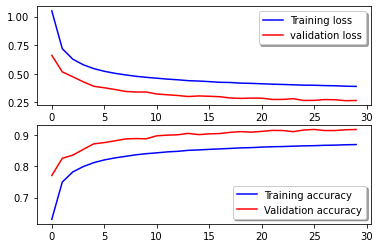

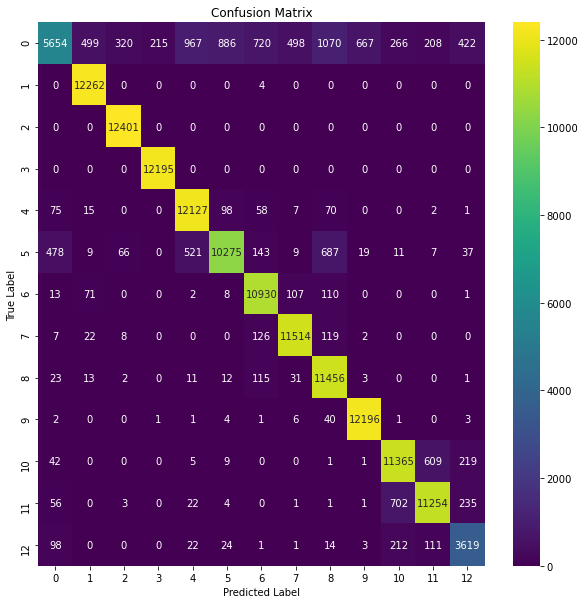

Test Accuracy: 91.76%
time elapsed : 221s


In [21]:
dnn = pipeline('dl',dnn)